In [1]:
import tensorflow as tf
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import utils

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test  = x_test  / 255.0

In [4]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

In [5]:
predictions = model(x_train[:1]).numpy()
predictions

array([[0.1776506 , 0.12525284, 0.14738432, 0.01533423, 0.121806  ,
        0.04708226, 0.6534639 , 0.5630951 , 0.24418032, 0.07949552]],
      dtype=float32)

In [6]:
tf.nn.softmax(predictions).numpy()

array([[0.0939189 , 0.08912447, 0.09111891, 0.07984725, 0.0888178 ,
        0.08242291, 0.1511458 , 0.13808593, 0.10037984, 0.08513826]],
      dtype=float32)

In [7]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [8]:
loss_fn(y_train[:1], predictions).numpy()

2.495892

In [9]:
model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

In [10]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2971 - accuracy: 0.9147
Epoch 2/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1428 - accuracy: 0.9577
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1066 - accuracy: 0.9676
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0872 - accuracy: 0.9729
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0749 - accuracy: 0.9762


In [11]:
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 0s - loss: 0.0763 - accuracy: 0.9760


[0.07633757591247559, 0.9760000109672546]

In [12]:
probability_model = tf.keras.Sequential([
  model,
#   tf.keras.layers.Softmax()
])

In [13]:
pngs = sorted(glob("data/pngs/*.png"))
def load_image(path):
    image     = tf.keras.preprocessing.image.load_img(path, color_mode="grayscale", target_size=(28,28), interpolation='nearest')
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    return input_arr / 255

actual_data = [load_image(png) for png in pngs]
actual_data = np.array(actual_data)
actual_data.shape

(37, 28, 28, 1)

C:\Users\verst\AppData\Local\Temp/ipykernel_9924/215207758.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(1, 2)


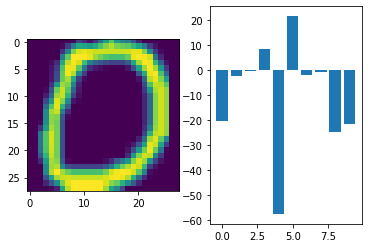

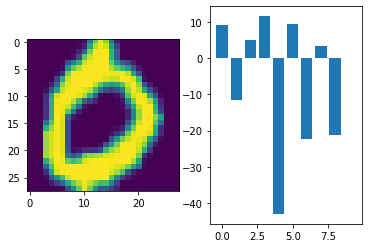

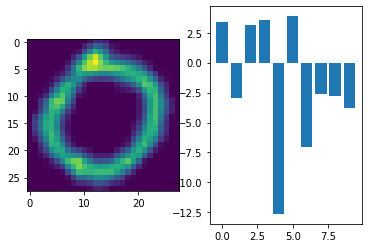

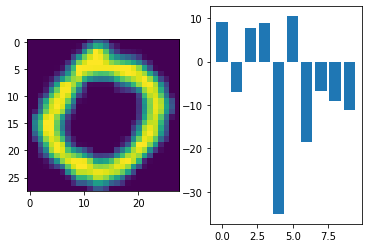

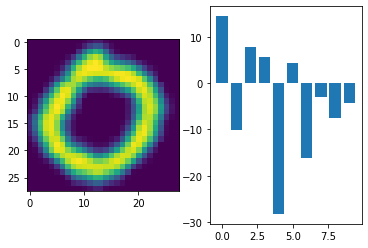

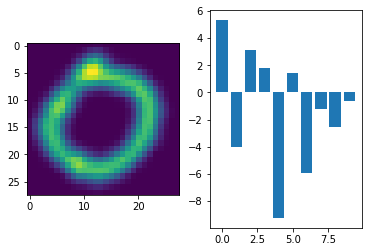

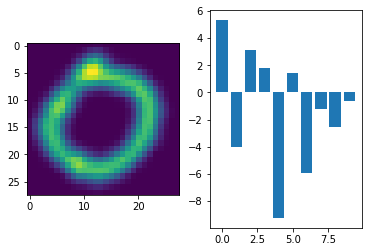

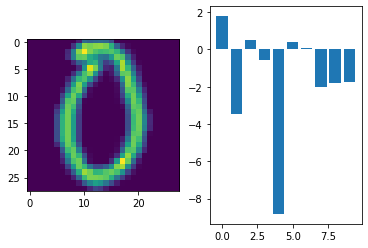

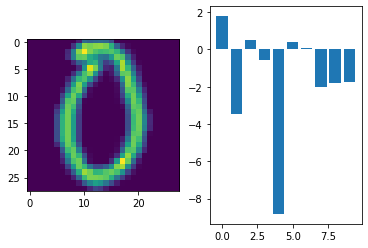

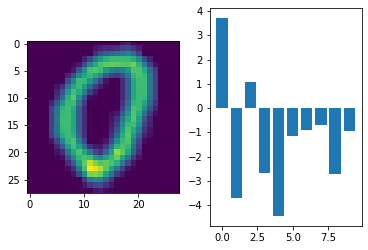

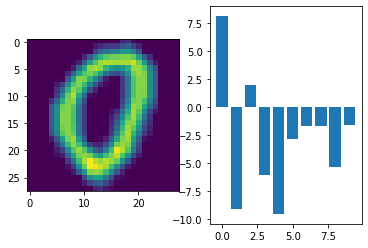

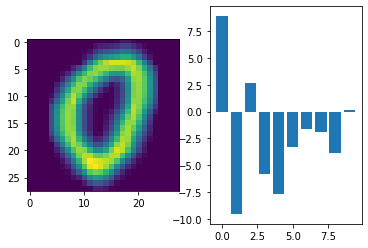

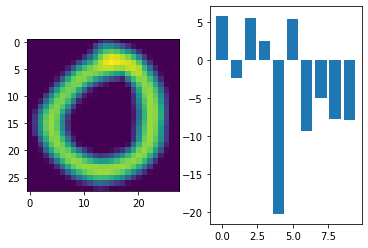

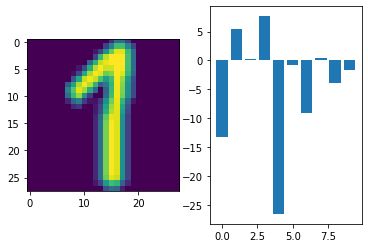

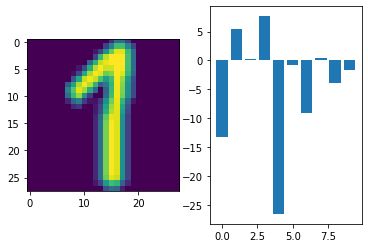

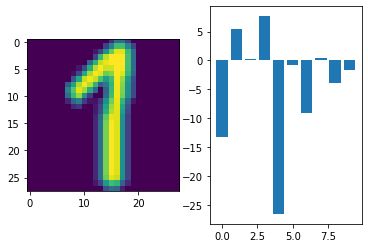

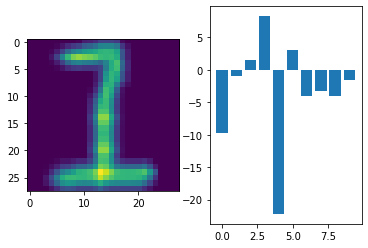

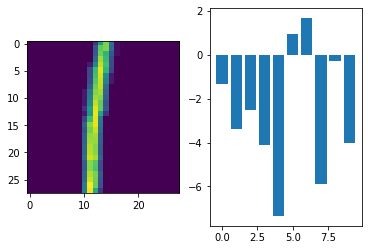

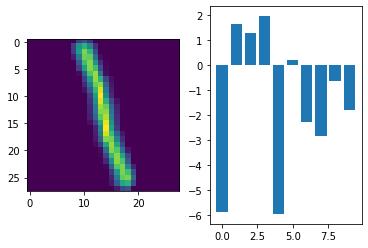

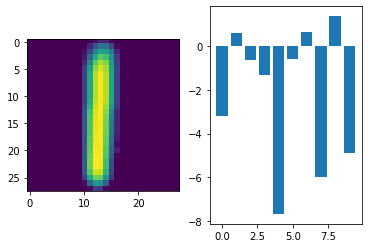

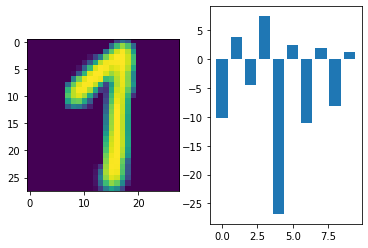

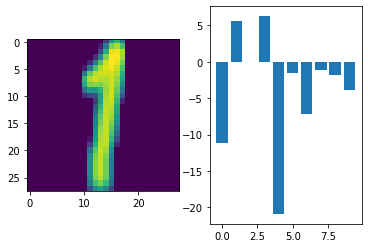

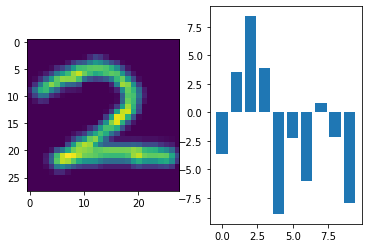

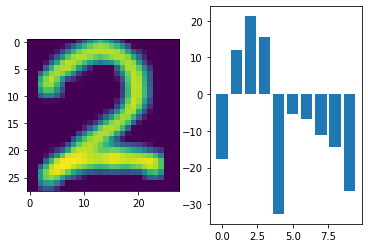

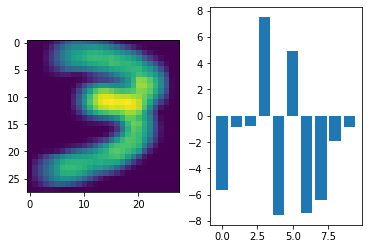

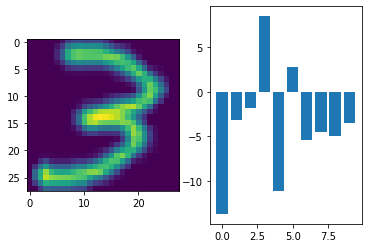

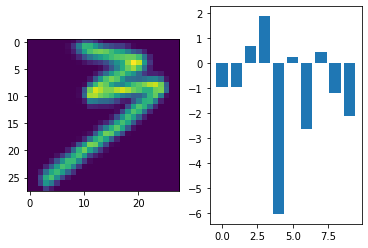

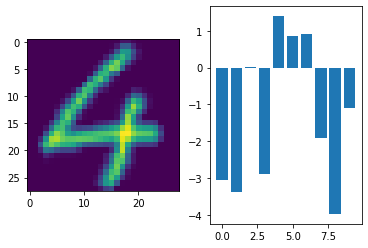

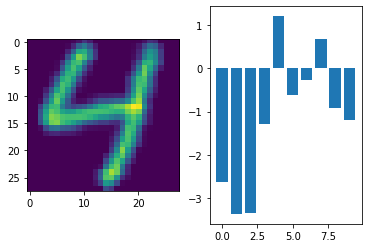

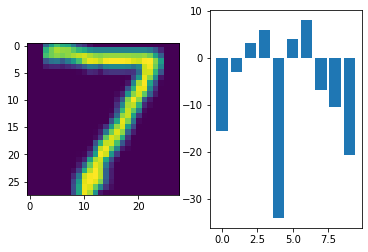

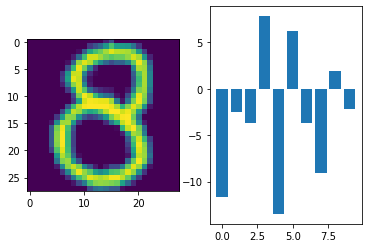

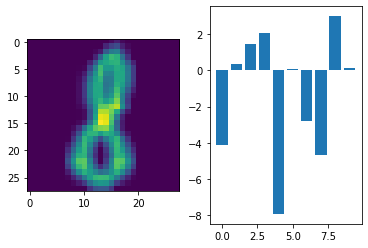

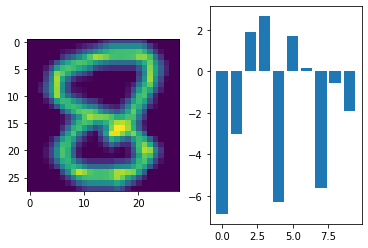

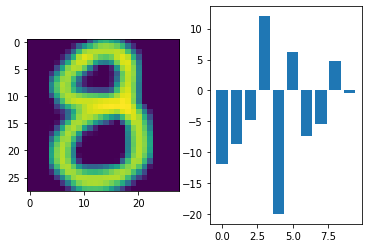

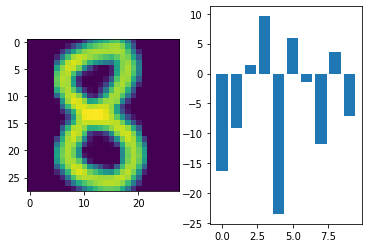

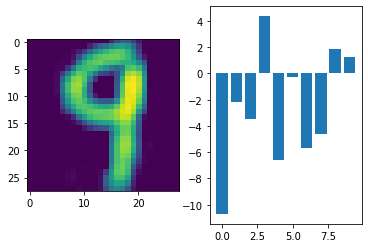

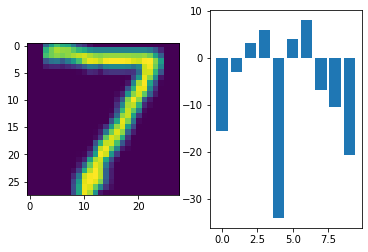

In [14]:
data = np.array([utils.zoom_to_bounds(img_array) for img_array in actual_data[:100]])
predictions = probability_model(data)
for i, d in enumerate(data):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(d)
    ax2.bar(x=range(0, 10), height=predictions[i])    